In [1]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import datetime

### Overview
The temperature sensors vastly underestimate the true temperature of the bed.  This is most likely due to the thermal gradient of the bed itself as the sensors are somewhat isolated from the bed.

This actually works to our advantage in some ways as the max temperature of the digital sensors is 120C and the max temperature of the analog sensor is 150C.  Although its an approximation, this means we can at least approximate temperatures higher than the working range of the temperature sensors themselves.

The next step is to create the approximation.  To do this, we collect ground truth data with a PT100 RTD affixed directly to the bed and use that as the reference for the approximation function.

For our model, we assume the plate is "lagged" such that minimal heat escapes from the sides.  Due to the proximity of the temperature sensor and the width of the bed, this is likely a valid assumption.  This assumption means we can assume a simple linear relationship such that Ttrue = Tanalog*m + b where Ttrue is the true temperature of the bed, Tanalog is the temperature as measured by the analog sensor, and m/b are arbitrary linear coefficients.

A basic regression can be used to obtain values for m and b from real world data.

In [2]:
with open("data/thermal_analysis3.log", 'r') as f:
    raw_data = f.readlines()

temps = []
curtemps = []
last_curtemps = []
times = []
for line in raw_data:
    if "Temps" in line:
        split = line.strip().split(" ")
        times.append(split[0])
        curtemps = [float(i) for i in split[2:6]]
    if "Groundtruth" in line:
        split = line.strip()[:-2].split(" ")
        curtemps.append(float(split[2]))
        for i in range(len(curtemps)):
            if curtemps[i] < 0:
                curtemps[i] = last_curtemps[i]
        
        temps.append(curtemps)
        last_curtemps = curtemps

names = ["analog", "d1", "d2", "d3", "groundtruth"]
times = [datetime.datetime.strptime(t, '[%H:%M:%S:%f]') for t in times]
#print(times)

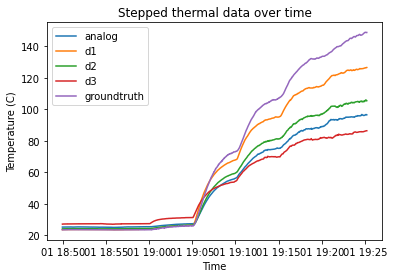

In [3]:
data = np.array(temps)

plt.figure()
for i, name in enumerate(names):
    plt.plot(times, data[:, i], label=name)
plt.legend()
plt.title("Stepped thermal data over time")
plt.ylabel("Temperature (C)")
plt.xlabel("Time")
plt.show()

1.7120640969035832 -20.517058041858043


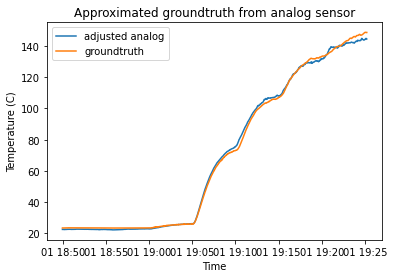

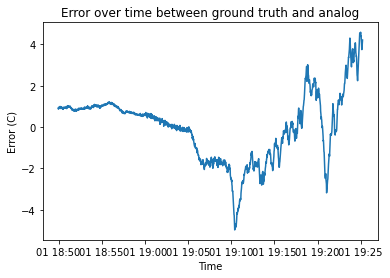

In [4]:
# regression between analog data and PT100 data
m,b = np.polyfit(data[:, 0], data[:, 4], 1)
print(m, b)
adjusted_analog = data[:, 0]*m + b


plt.figure()
plt.plot(times, adjusted_analog, label="adjusted analog")
plt.plot(times, data[:, 4], label="groundtruth")
plt.legend()
plt.title("Approximated groundtruth from analog sensor")
plt.ylabel("Temperature (C)")
plt.xlabel("Time")
plt.show()

error = data[:, 4] - adjusted_analog
plt.figure()
plt.plot(times, error)
plt.title("Error over time between ground truth and analog")
plt.ylabel("Error (C)")
plt.xlabel("Time")
plt.show()